In [2]:
import os
import sys

from dotenv import load_dotenv
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import sqlalchemy as db
from sqlalchemy.dialects.mysql import insert

In [3]:
# DATABASE CREDENTIALS
load_dotenv()
db_host = os.getenv('MYSQL_HOST')
db_user = os.getenv('MYSQL_USER')
db_pass = os.getenv('MYSQL_PASSWORD')
db_name = os.getenv('MYSQL_DATABASE')

In [ ]:
# TEST CONNECTION
try:
    engine = db.create_engine(f"mysql+pymysql://{db_user}:{db_pass}@{db_host}/{db_name}")
    with engine.connect() as conn:
        print("Test connection successful")
except db.exc.OperationalError as e:
    print(f"Failed to create engine: {e}")

Test connection successful


In [5]:
metadata = db.MetaData()
species_table = db.Table('species', metadata, autoload_with=engine)
species_table
locations_table = db.Table('locations', metadata, autoload_with=engine)
locations_table

Table('locations', MetaData(), Column('id', INTEGER(), table=<locations>, primary_key=True, nullable=False), Column('waterBody', VARCHAR(length=255), table=<locations>), schema=None)

In [6]:
with engine.connect() as conn:
    query = locations_table.select()
    print(query)
    exe = conn.execute(query)
    result = exe.fetchall()
    print(result)

SELECT locations.id, locations."waterBody" 
FROM locations
[(3, None), (0, 'Arctic Ocean'), (5, 'Indian Ocean'), (8, 'Mediterranean Region'), (1, 'North Atlantic Ocean'), (2, 'North Pacific Ocean'), (6, 'South Atlantic Ocean'), (9, 'South China and Easter Archipelagic Seas'), (7, 'South Pacific Ocean'), (4, 'Southern Ocean')]


In [7]:
with engine.connect() as conn:
    query = species_table.select()
    exe = conn.execute(query)
    result = exe.fetchall()
    print('RESULT \n', result)
#  or
# exe = conn.execute(db.text('SELECT * FROM species'))
# result = exe.fetchone()
# for row in exe:  # iterate through all returned results
#     print(row)

RESULT 
 [(137090, 'Balaenoptera musculus', 'Blue Whale'), (137102, 'Orcinus orca', 'Killer Whale'), (137112, 'Eschrichtius robustus', 'Gray Whale'), (137115, 'Delphinapterus leucas', 'Beluga Whale'), (137116, 'Monodon monoceros', 'Narwhal')]


In [ ]:
species_table = db.table('species')
t = db.text('SELECT * FROM species')
stmt = db.select(species_table)
# print(stmt)
with engine.begin() as conn:
    for row in conn.execute(t):
        print(row)

In [8]:
with engine.connect() as conn:
    locations_df = pd.read_sql(sql='SELECT * FROM locations;', con=conn)
    occurrences_df = pd.read_sql(sql='SELECT * FROM occurrences;', con=conn)

In [9]:
locations_df
occurrences_df

,id,eventDate,waterBodyId,latitude,longitude,speciesId,individualCount,start_year,start_month,start_day,end_year,end_month,end_day,date_is_valid
0,-1,1758-07-02,0,27.000000,51.000000,137090,1,1758,7,2,1758,7,2,1
1,-10,1997-12-28,0,-54.496277,158.938339,137102,3,1997,12,28,1997,12,28,1
2,-100,1996-12-16,0,-59.400002,102.817001,137102,2,1996,12,16,1996,12,16,1
3,-101,1996-01-28,0,-68.510368,77.384537,137102,17,1996,1,28,1996,1,28,1
4,-102,1996-09-06,0,-54.716972,158.857788,137102,5,1996,9,6,1996,9,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52731,urn:swobis:tan1802mammal:13,2018-02-17,0,-70.763000,172.557800,137102,3,2018,2,17,2018,2,17,1
52732,urn:swobis:tan1802mammal:48,2018-03-03,0,-69.224000,-177.055600,137090,1,2018,3,3,2018,3,3,1
52733,urn:swobis:tan1802mammal:55,2018-03-03,0,-69.158000,-177.162000,137102,10,2018,3,3,2018,3,3,1
52734,urn:swobis:tan1802mammal:71,2018-03-08,0,-66.930000,-176.257000,137090,3,2018,3,8,2018,3,8,1


In [10]:
# IS JOIN NECESSARY? IS S.SPECIESNAME NEEDED?
bw_sightings_query = """
SELECT o.id as eventId, o.eventDate as date, o.waterBodyId, o.latitude, o.longitude, 
o.speciesId, s.speciesName, o.individualCount, o.date_is_valid
FROM occurrences o 
INNER JOIN species s ON o.speciesId = s.id
WHERE o.speciesId = 137090;
"""
with engine.connect() as conn:
    bw_sightings_df = pd.read_sql(bw_sightings_query, conn)
bw_sightings_df

,eventId,date,waterBodyId,latitude,longitude,speciesId,speciesName,individualCount,date_is_valid
0,-1,1758-07-02,0,27.0000,51.0000,137090,Balaenoptera musculus,1,1
1,0288c250-9625-4a6c-902e-7592138f2cc3,2004-12-02,0,-37.3953,139.2828,137090,Balaenoptera musculus,2,1
2,03968483-4d20-498b-b9ad-b6c1d53133d5,2003-12-06,0,-35.6100,135.1317,137090,Balaenoptera musculus,3,1
3,044150cd-b519-4bd4-8c3a-3cc6588e8467,2003-12-12,0,-37.0467,137.8267,137090,Balaenoptera musculus,1,1
4,04671c47-9ab3-4dbf-88b1-67e88515c5e6,2003-12-07,0,-35.0517,134.0567,137090,Balaenoptera musculus,1,1
...,...,...,...,...,...,...,...,...,...
19260,urn:NIWA:TerraNovaExp:391,1910-12-25,0,-69.0167,-178.4667,137090,Balaenoptera musculus,1,1
19261,urn:NIWA:TerraNovaExp:392,1910-12-26,0,-69.1500,-178.2167,137090,Balaenoptera musculus,1,1
19262,urn:NIWA:TerraNovaExp:395,1911-01-31,0,-78.5000,-170.5833,137090,Balaenoptera musculus,1,1
19263,urn:swobis:tan1802mammal:48,2018-03-03,0,-69.2240,-177.0556,137090,Balaenoptera musculus,1,1


In [11]:
bw_oceans_sighted_df = bw_sightings_df.merge(locations_df, left_on='waterBodyId', right_on='id', how='inner')
bw_oceans_sighted_df

,eventId,date,waterBodyId,latitude,longitude,speciesId,speciesName,individualCount,date_is_valid,id,waterBody
0,-1,1758-07-02,0,27.0000,51.0000,137090,Balaenoptera musculus,1,1,0,Arctic Ocean
1,0288c250-9625-4a6c-902e-7592138f2cc3,2004-12-02,0,-37.3953,139.2828,137090,Balaenoptera musculus,2,1,0,Arctic Ocean
2,03968483-4d20-498b-b9ad-b6c1d53133d5,2003-12-06,0,-35.6100,135.1317,137090,Balaenoptera musculus,3,1,0,Arctic Ocean
3,044150cd-b519-4bd4-8c3a-3cc6588e8467,2003-12-12,0,-37.0467,137.8267,137090,Balaenoptera musculus,1,1,0,Arctic Ocean
4,04671c47-9ab3-4dbf-88b1-67e88515c5e6,2003-12-07,0,-35.0517,134.0567,137090,Balaenoptera musculus,1,1,0,Arctic Ocean
...,...,...,...,...,...,...,...,...,...,...,...
19260,urn:NIWA:TerraNovaExp:391,1910-12-25,0,-69.0167,-178.4667,137090,Balaenoptera musculus,1,1,0,Arctic Ocean
19261,urn:NIWA:TerraNovaExp:392,1910-12-26,0,-69.1500,-178.2167,137090,Balaenoptera musculus,1,1,0,Arctic Ocean
19262,urn:NIWA:TerraNovaExp:395,1911-01-31,0,-78.5000,-170.5833,137090,Balaenoptera musculus,1,1,0,Arctic Ocean
19263,urn:swobis:tan1802mammal:48,2018-03-03,0,-69.2240,-177.0556,137090,Balaenoptera musculus,1,1,0,Arctic Ocean


In [13]:
# COUNTRIES DATASET
# countries = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')) deprecated
countries = gpd.read_file('./ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp', )
countries

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry
0,Admin-0 country,1,6,Fiji,FJI,0,2,Sovereign country,1,Fiji,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((180 -16.06713, 180 -16.55522, ..."
1,Admin-0 country,1,3,United Republic of Tanzania,TZA,0,2,Sovereign country,1,United Republic of Tanzania,...,None,None,None,None,None,None,None,None,None,"POLYGON ((33.90371 -0.95, 34.07262 -1.05982, 3..."
2,Admin-0 country,1,7,Western Sahara,SAH,0,2,Indeterminate,1,Western Sahara,...,Unrecognized,Unrecognized,Unrecognized,None,None,Unrecognized,None,None,None,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,Admin-0 country,1,2,Canada,CAN,0,2,Sovereign country,1,Canada,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-122.84 49, -122.97421 49.0025..."
4,Admin-0 country,1,2,United States of America,US1,1,2,Country,1,United States of America,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-122.84 49, -120 49, -117.0312..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,Admin-0 country,1,5,Republic of Serbia,SRB,0,2,Sovereign country,1,Republic of Serbia,...,None,None,None,None,None,None,None,None,None,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,Admin-0 country,1,6,Montenegro,MNE,0,2,Sovereign country,1,Montenegro,...,None,None,None,None,None,None,None,None,None,"POLYGON ((20.0707 42.58863, 19.80161 42.50009,..."
174,Admin-0 country,1,6,Kosovo,KOS,0,2,Disputed,1,Kosovo,...,Admin-0 country,Unrecognized,Admin-0 country,Unrecognized,Admin-0 country,Admin-0 country,Admin-0 country,Admin-0 country,Unrecognized,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,Admin-0 country,1,5,Trinidad and Tobago,TTO,0,2,Sovereign country,1,Trinidad and Tobago,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-61.68 10.76, -61.105 10.89, -60.895..."


/opt/conda/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:1351: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


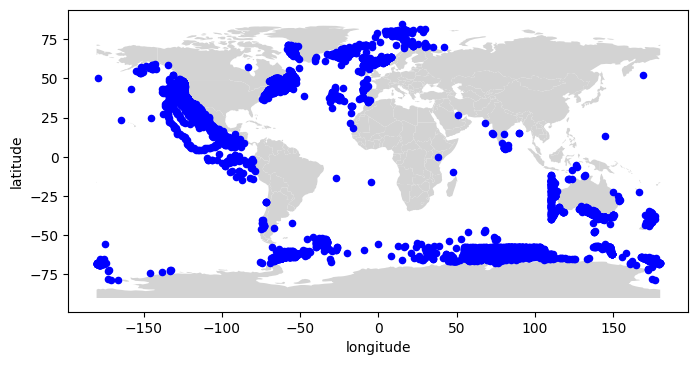

In [14]:
fig, ax = plt.subplots(figsize=(8,7))

countries.plot(color='lightgrey', ax=ax)
# occurrences_df.plot('longitude', 'latitude', kind='scatter', c='blue', colormap='YlOrRd', ax=ax)
bw_oceans_sighted_df.plot('longitude', 'latitude', kind='scatter', c='blue', colormap='YlOrRd', ax=ax)

plt.show()

In [24]:
from dateutil.parser import parse
bw_oceans_sighted_df = bw_oceans_sighted_df[bw_oceans_sighted_df['date_is_valid'] == True]
bw_oceans_sighted_df
bw_oceans_years_sighted_df = bw_oceans_sighted_df['date'].apply(lambda x: parse(x).year)
# bw_oceans_years_sighted_df
# sorted(bw_oceans_years_sighted_df.unique())
sightings_per_year = bw_oceans_years_sighted_df.value_counts()
sightings_per_year = pd.DataFrame({'date': sightings_per_year.index, 'num_sightings': sightings_per_year.values})
# sightings_per_year = sightings_per_year.to_frame(name='num_sightings').reset_index()
sightings_per_year = sightings_per_year[(sightings_per_year['date'] >= 2000) & (sightings_per_year['date'] < 2025)]
sightings_per_year

,date,num_sightings
0,2020,1161
1,2019,1103
2,2003,881
3,2021,815
4,2018,634
5,2004,464
6,2013,433
7,2002,392
8,2017,370
9,2006,370


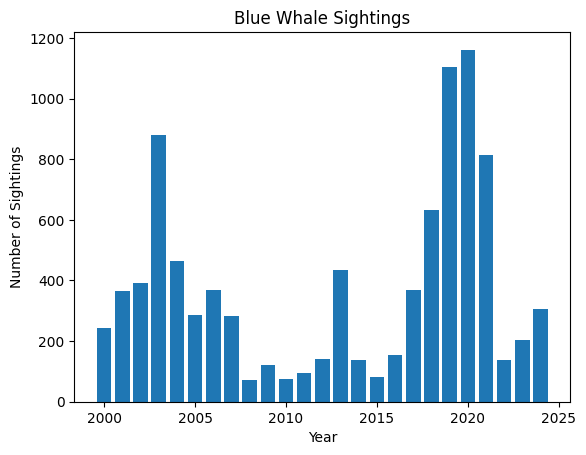

In [17]:
fig, ax = plt.subplots()

ax.bar(sightings_per_year['date'], sightings_per_year['num_sightings'])
ax.set(xlabel="Year", ylabel='Number of Sightings', title="Blue Whale Sightings")
plt.show()